SET UP THE ENVIRONMENT

In [163]:
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor, XGBClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from catboost import CatBoostRegressor
from sklearn.decomposition import PCA


IMPORTING THE DATASET

In [164]:
train = pd.read_csv('trainPredicting Sales Quantity.csv')
test = pd.read_csv('testPredicting Sales Quantity.csv')
supp_cit = pd.read_csv('supplemental_cities.csv')

supp_cit.sample(5),   train.sample(5)

(        city_id  population  education_level  median_income
 6875   48/136/0     11399.0                6    1782.957676
 1313     9/43/1      8026.0                6    1584.690920
 7783    55/44/0     10156.0                5    1751.724499
 7632    54/43/1     19103.0                5    1652.770481
 10062  70/141/0      5219.0                7    1975.902278,
           id   city_id  price  store_id  quantity  ad_level
 18192  30368  125/34/0   5.50         2    2193.0       6.0
 19717  32800  135/33/0   5.75         0    1400.0       1.0
 5831    9706   38/94/0   6.00         2    1374.0       1.0
 13196  22139   91/90/0   6.00         1    2045.0       5.0
 15297  25753  106/44/0   5.00         0    3140.0       5.0)

In [165]:
Id = pd.DataFrame(test['id'], columns=['id'])
test = test.drop('id',axis = 1)
train = train.drop('id',axis = 1)

EXTRACTING CITY COORDINATES

In [166]:
def extracting_coordinates(df):
    df['x'] = df['city_id'].apply(lambda x : int(x.split('/')[0]))
    df['y'] = df['city_id'].apply(lambda x : int(x.split('/')[1]))
    df['city_nr'] = df['city_id'].apply(lambda x : int(x.split('/')[2]))
    

In [167]:
extracting_coordinates(train)
extracting_coordinates(test)
extracting_coordinates(supp_cit)

In [168]:
train.head(5)

,city_id,price,store_id,quantity,ad_level,x,y,city_nr
0,0/0/0,6.00,0,2240.0,6.0,0,0,0
1,0/4/0,6.00,0,2558.0,3.0,0,4,0
2,0/9/1,5.25,0,2316.0,2.0,0,9,1
3,0/11/0,6.25,0,2276.0,5.0,0,11,0
4,0/13/0,6.00,0,1800.0,2.0,0,13,0


In [169]:
test.head(4)

,city_id,price,store_id,ad_level,x,y,city_nr
0,0/1/0,5.00,0,3.0,0,1,0
1,0/1/0,5.75,1,5.0,0,1,0
2,0/6/0,5.00,0,3.0,0,6,0
3,0/7/0,6.25,0,3.0,0,7,0


SCATTERPLOT OF CITIES WRT POPULATION

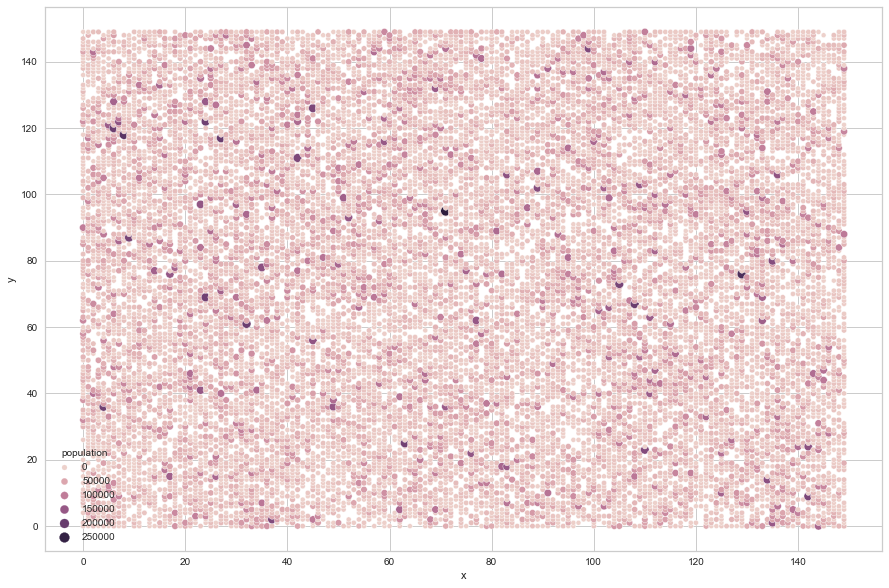

In [170]:
cities = supp_cit.groupby(['x','y'])['population'].sum().to_frame()
plt.figure(figsize=(15, 10))
sns.scatterplot(data = cities, x = 'x', y = 'y', hue = 'population', size = 'population')
plt.show()

In [171]:
supp_cit.isna().sum()

city_id              0
population         408
education_level      0
median_income      413
x                    0
y                    0
city_nr              0
dtype: int64

KNN IMPUTATION

In [172]:
imputer = KNNImputer(n_neighbors=5)
X = supp_cit.drop('city_id', axis = 1)
sup_imp = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index = X.index)
supp_cit = sup_imp.merge(supp_cit['city_id'], left_index = True, right_index = True)
supp_cit.head()

,population,education_level,median_income,x,y,city_nr,city_id
0,9868.0,5.0,1478.732661,0.0,0.0,0.0,0/0/0
1,15542.0,5.0,1553.116245,0.0,1.0,0.0,0/1/0
2,7446.0,6.0,1612.926622,0.0,4.0,0.0,0/4/0
3,887.0,6.0,1331.923281,0.0,6.0,0.0,0/6/0
4,15772.0,6.0,1747.276726,0.0,7.0,0.0,0/7/0


In [173]:
supp_cit.isna().sum()

population         0
education_level    0
median_income      0
x                  0
y                  0
city_nr            0
city_id            0
dtype: int64

CREATING A NEW FEATURE USING CLUSTERING

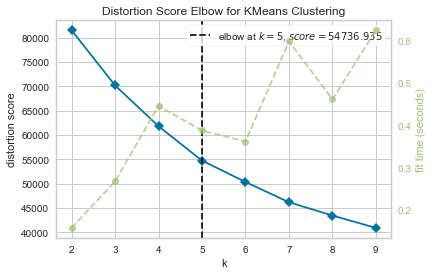

In [174]:
df = supp_cit[['x','y','population','education_level','median_income']]
scl = StandardScaler()
s_df = pd.DataFrame(scl.fit_transform(df), columns=df.columns, index = df.index)

model = KMeans(random_state = 42, n_init=10)
visualizer = KElbowVisualizer(model, k=(2,10))
visualizer.fit(s_df)  
visualizer.show()
plt.show()

In [175]:
optimal_clusters = visualizer.elbow_value_
kmeans = KMeans(n_clusters= optimal_clusters , random_state = 42, n_init=10)
supp_cit['location'] = kmeans.fit_predict(s_df)

VISULISATION OF FORMED CLUSTERS ('LOCATION')

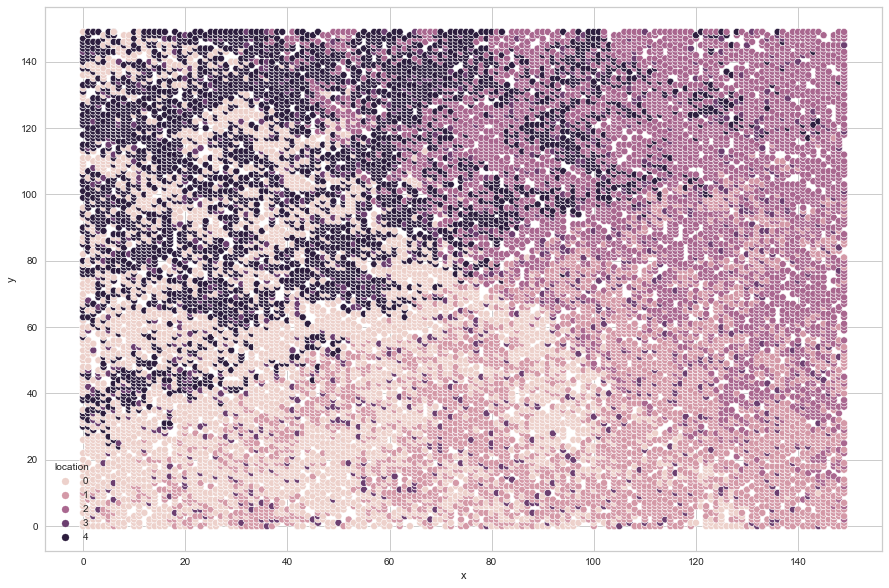

In [176]:
cities = supp_cit.groupby(['x','y','location'])['population'].sum().to_frame()
plt.figure(figsize=(15, 10))
sns.scatterplot(data = supp_cit, x = 'x', y = 'y', hue = 'location')
plt.show()

FINDING NUMBER OF CITIES PER COORDINATE

In [177]:
supp_cit['no_of_city'] = supp_cit.groupby(['x','y'])['city_nr'].transform('count')
supp_cit.head()

,population,education_level,median_income,x,y,city_nr,city_id,location,no_of_city
0,9868.0,5.0,1478.732661,0.0,0.0,0.0,0/0/0,0,1
1,15542.0,5.0,1553.116245,0.0,1.0,0.0,0/1/0,0,1
2,7446.0,6.0,1612.926622,0.0,4.0,0.0,0/4/0,0,1
3,887.0,6.0,1331.923281,0.0,6.0,0.0,0/6/0,0,1
4,15772.0,6.0,1747.276726,0.0,7.0,0.0,0/7/0,0,2


In [178]:
train = train.merge(supp_cit[['population','education_level','median_income','x','y','no_of_city','location','city_id']],left_on='city_id', right_on='city_id')
test = test.merge(supp_cit[['population','education_level','median_income','x','y','no_of_city','location','city_id']],left_on='city_id', right_on='city_id')

train.head(), test.head()

(  city_id  price  store_id  quantity  ad_level  x_x  y_x  city_nr  population  \
 0   0/0/0   6.00         0    2240.0       6.0    0    0        0      9868.0   
 1   0/4/0   6.00         0    2558.0       3.0    0    4        0      7446.0   
 2   0/9/1   5.25         0    2316.0       2.0    0    9        1      2029.0   
 3  0/11/0   6.25         0    2276.0       5.0    0   11        0      4418.0   
 4  0/13/0   6.00         0    1800.0       2.0    0   13        0      3932.0   
 
    education_level  median_income  x_y   y_y  no_of_city  location  
 0              5.0    1478.732661  0.0   0.0           1         0  
 1              6.0    1612.926622  0.0   4.0           1         0  
 2              5.0    1403.120891  0.0   9.0           2         0  
 3              6.0    1555.556995  0.0  11.0           1         0  
 4              5.0    1431.114759  0.0  13.0           1         0  ,
   city_id  price  store_id  ad_level  x_x  y_x  city_nr  population  \
 0   0/1/0   

In [179]:
train.head()

,city_id,price,store_id,quantity,ad_level,x_x,y_x,city_nr,population,education_level,median_income,x_y,y_y,no_of_city,location
0,0/0/0,6.00,0,2240.0,6.0,0,0,0,9868.0,5.0,1478.732661,0.0,0.0,1,0
1,0/4/0,6.00,0,2558.0,3.0,0,4,0,7446.0,6.0,1612.926622,0.0,4.0,1,0
2,0/9/1,5.25,0,2316.0,2.0,0,9,1,2029.0,5.0,1403.120891,0.0,9.0,2,0
3,0/11/0,6.25,0,2276.0,5.0,0,11,0,4418.0,6.0,1555.556995,0.0,11.0,1,0
4,0/13/0,6.00,0,1800.0,2.0,0,13,0,3932.0,5.0,1431.114759,0.0,13.0,1,0


In [180]:
imputer = KNNImputer(n_neighbors=5)
X = train.drop(['city_id'], axis = 1)
sup_imp = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index = X.index)
train = sup_imp.merge(train['city_id'], left_index = True, right_index = True)
train.head()




,price,store_id,quantity,ad_level,x_x,y_x,city_nr,population,education_level,median_income,x_y,y_y,no_of_city,location,city_id
0,6.00,0.0,2240.0,6.0,0.0,0.0,0.0,9868.0,5.0,1478.732661,0.0,0.0,1.0,0.0,0/0/0
1,6.00,0.0,2558.0,3.0,0.0,4.0,0.0,7446.0,6.0,1612.926622,0.0,4.0,1.0,0.0,0/4/0
2,5.25,0.0,2316.0,2.0,0.0,9.0,1.0,2029.0,5.0,1403.120891,0.0,9.0,2.0,0.0,0/9/1
3,6.25,0.0,2276.0,5.0,0.0,11.0,0.0,4418.0,6.0,1555.556995,0.0,11.0,1.0,0.0,0/11/0
4,6.00,0.0,1800.0,2.0,0.0,13.0,0.0,3932.0,5.0,1431.114759,0.0,13.0,1.0,0.0,0/13/0


In [181]:
imputer = KNNImputer(n_neighbors=5)
X = test.drop(['city_id'], axis = 1)
sup_imp = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index = X.index)
test = sup_imp.merge(test['city_id'], left_index = True, right_index = True)
test.head()



,price,store_id,ad_level,x_x,y_x,city_nr,population,education_level,median_income,x_y,y_y,no_of_city,location,city_id
0,5.00,0.0,3.0,0.0,1.0,0.0,15542.0,5.0,1553.116245,0.0,1.0,1.0,0.0,0/1/0
1,5.75,1.0,5.0,0.0,1.0,0.0,15542.0,5.0,1553.116245,0.0,1.0,1.0,0.0,0/1/0
2,5.00,0.0,3.0,0.0,6.0,0.0,887.0,6.0,1331.923281,0.0,6.0,1.0,0.0,0/6/0
3,6.25,0.0,3.0,0.0,7.0,0.0,15772.0,6.0,1747.276726,0.0,7.0,2.0,0.0,0/7/0
4,6.50,0.0,5.0,0.0,7.0,1.0,9836.0,6.0,1697.075374,0.0,7.0,2.0,0.0,0/7/1


MODEL TRAINING AND TESTING

In [182]:
train.head(5)

,price,store_id,quantity,ad_level,x_x,y_x,city_nr,population,education_level,median_income,x_y,y_y,no_of_city,location,city_id
0,6.00,0.0,2240.0,6.0,0.0,0.0,0.0,9868.0,5.0,1478.732661,0.0,0.0,1.0,0.0,0/0/0
1,6.00,0.0,2558.0,3.0,0.0,4.0,0.0,7446.0,6.0,1612.926622,0.0,4.0,1.0,0.0,0/4/0
2,5.25,0.0,2316.0,2.0,0.0,9.0,1.0,2029.0,5.0,1403.120891,0.0,9.0,2.0,0.0,0/9/1
3,6.25,0.0,2276.0,5.0,0.0,11.0,0.0,4418.0,6.0,1555.556995,0.0,11.0,1.0,0.0,0/11/0
4,6.00,0.0,1800.0,2.0,0.0,13.0,0.0,3932.0,5.0,1431.114759,0.0,13.0,1.0,0.0,0/13/0


In [189]:
train['total_stores'] = train.groupby(['city_id'])['store_id'].transform('count')
train.head()

,price,store_id,quantity,ad_level,x_x,y_x,city_nr,population,education_level,median_income,x_y,y_y,no_of_city,location,city_id,total_stores
0,6.00,0.0,2240.0,6.0,0.0,0.0,0.0,9868.0,5.0,1478.732661,0.0,0.0,1.0,0.0,0/0/0,1
1,6.00,0.0,2558.0,3.0,0.0,4.0,0.0,7446.0,6.0,1612.926622,0.0,4.0,1.0,0.0,0/4/0,1
2,5.25,0.0,2316.0,2.0,0.0,9.0,1.0,2029.0,5.0,1403.120891,0.0,9.0,2.0,0.0,0/9/1,1
3,6.25,0.0,2276.0,5.0,0.0,11.0,0.0,4418.0,6.0,1555.556995,0.0,11.0,1.0,0.0,0/11/0,1
4,6.00,0.0,1800.0,2.0,0.0,13.0,0.0,3932.0,5.0,1431.114759,0.0,13.0,1.0,0.0,0/13/0,1


In [195]:
test['total_stores'] = test.groupby(['city_id'])['store_id'].transform('count')
test.head()

,price,store_id,ad_level,x_x,y_x,city_nr,population,education_level,median_income,x_y,y_y,no_of_city,location,city_id,per_capita_income,total_stores
0,5.00,0.0,3.0,0.0,1.0,0.0,15542.0,5.0,1553.116245,0.0,1.0,1.0,0.0,0/1/0,0.099930,2
1,5.75,1.0,5.0,0.0,1.0,0.0,15542.0,5.0,1553.116245,0.0,1.0,1.0,0.0,0/1/0,0.099930,2
2,5.00,0.0,3.0,0.0,6.0,0.0,887.0,6.0,1331.923281,0.0,6.0,1.0,0.0,0/6/0,1.501605,1
3,6.25,0.0,3.0,0.0,7.0,0.0,15772.0,6.0,1747.276726,0.0,7.0,2.0,0.0,0/7/0,0.110783,1
4,6.50,0.0,5.0,0.0,7.0,1.0,9836.0,6.0,1697.075374,0.0,7.0,2.0,0.0,0/7/1,0.172537,1


In [190]:


X = train.drop(columns=['quantity','city_id','x_y','y_y'], axis = 1)
y = train['quantity']


X['per_capita_income'] = X['median_income'] / X['population']
X = X.drop(columns=['median_income','population'], axis = 1)


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=40)
X_train.head()

,price,store_id,ad_level,x_x,y_x,city_nr,education_level,no_of_city,location,total_stores,per_capita_income
16221,6.00,0.0,0.0,111.0,137.0,1.0,6.0,2.0,4.0,2,0.177189
3036,5.75,0.0,2.0,20.0,124.0,0.0,6.0,2.0,4.0,1,2.238138
6647,5.00,1.0,6.0,44.0,123.0,0.0,6.0,2.0,4.0,4,0.050236
12099,6.50,4.0,3.0,82.0,76.0,0.0,6.0,2.0,3.0,5,0.052213
8125,5.00,0.0,3.0,55.0,69.0,0.0,7.0,2.0,4.0,2,0.079401


In [191]:

cat = CatBoostRegressor(random_state=42)



rmse = {}


cat.fit(X_train, y_train)
y_pred = cat.predict(X_val)
print(np.sqrt(mean_squared_error(y_val, y_pred)))



Learning rate set to 0.064257
0:	learn: 960.1725537	total: 7ms	remaining: 6.99s
1:	learn: 915.9355474	total: 10.7ms	remaining: 5.36s
2:	learn: 873.8393215	total: 20.6ms	remaining: 6.84s
3:	learn: 834.9012488	total: 33.2ms	remaining: 8.27s
4:	learn: 797.4817560	total: 43.8ms	remaining: 8.72s
5:	learn: 763.5580051	total: 47.7ms	remaining: 7.9s
6:	learn: 731.4958253	total: 61.9ms	remaining: 8.78s
7:	learn: 700.9270369	total: 66.8ms	remaining: 8.28s
8:	learn: 673.9185396	total: 70.5ms	remaining: 7.76s
9:	learn: 647.9610275	total: 73.9ms	remaining: 7.32s
10:	learn: 622.6673243	total: 76.9ms	remaining: 6.91s
11:	learn: 599.7667082	total: 80.4ms	remaining: 6.62s
12:	learn: 578.0722554	total: 83.5ms	remaining: 6.34s
13:	learn: 559.0940678	total: 86.7ms	remaining: 6.11s
14:	learn: 541.9882272	total: 89.9ms	remaining: 5.91s
15:	learn: 524.6537072	total: 93ms	remaining: 5.72s
16:	learn: 508.7523977	total: 96.1ms	remaining: 5.56s
17:	learn: 493.8995029	total: 99.2ms	remaining: 5.41s
18:	learn: 481

In [192]:
param_grid = {
    'learning_rate':[0.01, 0.05, 0.1],
    'max_depth':[3,5,7,10,20],
    'n_estimators':[50,100,150,200],
    
}

cat_grid = GridSearchCV(CatBoostRegressor(random_state = 42),
                        param_grid,
                        cv = 3,
                        scoring = 'neg_mean_squared_error',
                        verbose = 2,
                        n_jobs = -1)

cat_grid.fit(X_train, y_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
36 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/catboost/core.py", line 5351, in fit
    return self._fit(X, y, cat_features, None, None, None, sample_weight, None, None, None, None, baseline,
  File "/opt/anaconda3/lib/python3.8/site-packages/catboost/core.py", line 2073, in _fit
    train_params = self.

0:	learn: 927.7381451	total: 15.9ms	remaining: 3.17s
1:	learn: 851.9666299	total: 27.9ms	remaining: 2.76s
2:	learn: 787.9610657	total: 40.6ms	remaining: 2.67s
3:	learn: 734.5689284	total: 45.5ms	remaining: 2.23s
4:	learn: 682.5583876	total: 56.8ms	remaining: 2.21s
5:	learn: 634.1600806	total: 68.5ms	remaining: 2.21s
6:	learn: 590.2970521	total: 84.3ms	remaining: 2.32s
7:	learn: 552.6350791	total: 102ms	remaining: 2.44s
8:	learn: 517.4473189	total: 128ms	remaining: 2.71s
9:	learn: 487.2303873	total: 143ms	remaining: 2.71s
10:	learn: 459.2984679	total: 155ms	remaining: 2.66s
11:	learn: 435.3513210	total: 171ms	remaining: 2.68s
12:	learn: 413.1628851	total: 182ms	remaining: 2.61s
13:	learn: 393.9095967	total: 193ms	remaining: 2.57s
14:	learn: 375.0613046	total: 204ms	remaining: 2.52s
15:	learn: 358.8198449	total: 214ms	remaining: 2.46s
16:	learn: 345.1263251	total: 230ms	remaining: 2.48s
17:	learn: 332.7877699	total: 247ms	remaining: 2.5s
18:	learn: 321.2397227	total: 262ms	remaining: 2.4

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x157919e80>,
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7, 10, 20],
                         'n_estimators': [50, 100, 150, 200]},
             scoring='neg_mean_squared_error', verbose=2)

In [193]:
y_pred = cat_grid.predict(X_val)
print(np.sqrt(mean_squared_error(y_val, y_pred)))


214.85749141471763


In [196]:
test['per_capita_income'] = test['median_income'] / test['population']

test_encoded = test.drop(['city_id','x_y','y_y','median_income','population'],axis = 1)

y_test_pred = cat_grid.predict(test_encoded)
    

    

In [197]:
for i in range(len(y_test_pred)):
    y_test_pred[i] = round(y_test_pred[i])
    
submission = pd.concat([Id['id'].astype(int), pd.DataFrame(y_test_pred,columns=['quantity'])], axis = 1)

In [198]:
submission.to_csv('submission_Predicting Sales Quantity.csv', index = False)

In [199]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14392 entries, 0 to 14391
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        14392 non-null  int64  
 1   quantity  14392 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 225.0 KB


In [200]:
submission

,id,quantity
0,1,3354.0
1,2,2667.0
2,4,1878.0
3,5,3122.0
4,6,2791.0
...,...,...
14387,36047,1041.0
14388,36048,1330.0
14389,36053,4029.0
14390,36057,3258.0
